In [1]:
%tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
1.15.0


In [2]:
# 需要安裝 keras 2.2.4 的版本, 否則訓練時會出現 error
!pip install keras==2.2.4

     |████████████████████████████████| 317kB 6.8MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [3]:
import keras
print(keras.__version__)

2.2.4


Using TensorFlow backend.


In [26]:
from google.colab import drive
drive.mount('/content/gdrive') # 將 google drive 掛載在 colob

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [27]:
%cd '/content/gdrive/My Drive'

# 下載基於 keras 的 yolov3 程式碼
import os
if not os.path.exists("keras-yolo3") :
  !git clone https://github.com/qqwweee/keras-yolo3
else :
  print("keras-yolo3 exists")

%cd keras-yolo3
!ls

/content/gdrive/My Drive
keras-yolo3 exists
/content/gdrive/My Drive/keras-yolo3
annotation_xml	    LICENSE	     train_bottleneck.py  yolo.py
class.txt	    logs	     train_labels.txt	  yolov3.cfg
coco_annotation.py  model_data	     train.py		  yolov3-tiny.cfg
convert.py	    __pycache__      val		  yolov3.weights
darknet53.cfg	    raccoon_dataset  val_labels.txt	  yolo_video.py
font		    README.md	     video
kangaroo	    test	     voc_annotation.py
kmeans.py	    train	     yolo3


In [6]:
# model_data/yolo.h5 模型 & 權重
# 下載 yolov3 的網路權重，並且把權重轉換為 keras 能夠讀取的格式
if not os.path.exists("model_data/yolo.h5"):
  # 下載 yolov3 的網路權重
  print("Model doesn't exist, downloading...")
  os.system("wget https://pjreddie.com/media/files/yolov3.weights")
  
  # 把權重轉換為 keras 能夠讀取的格式(.h5)
  print("Converting yolov3.weights to yolo.h5...")
  os.system("python convert.py yolov3.cfg yolov3.weights model_data/yolo.h5")
else:
  print("Model exist")

Model doesn't exist, downloading...
Converting yolov3.weights to yolo.h5...


In [7]:
# 下載 raccoon 與 kangaroo 的資料集
if not os.path.exists("raccoon_dataset"):
  !git clone https://github.com/experiencor/raccoon_dataset.git  # 下載 raccoon_dataset 資料集
else:
  print("raccoon_dataset exists")

if not os.path.exists("kangaroo"):
  !git clone https://github.com/experiencor/kangaroo.git  # 下載 kangaroo 資料集
else:
  print("kangaroo exists")

Cloning into 'raccoon_dataset'...
remote: Enumerating objects: 646, done.
remote: Total 646 (delta 0), reused 0 (delta 0), pack-reused 646
Receiving objects: 100% (646/646), 48.00 MiB | 18.44 MiB/s, done.
Resolving deltas: 100% (412/412), done.
Checking out files: 100% (419/419), done.
Cloning into 'kangaroo'...
remote: Enumerating objects: 334, done.
remote: Total 334 (delta 0), reused 0 (delta 0), pack-reused 334
Receiving objects: 100% (334/334), 18.39 MiB | 13.33 MiB/s, done.
Resolving deltas: 100% (158/158), done.
Checking out files: 100% (329/329), done.


In [28]:
# 下載浣熊與袋鼠影片
if not os.path.exists("video"):
  !mkdir video
  !wget -c 'https://cvdl.cupoy.com/HomeworkAction.do?op=getHomeworkFileContent&hwid=D49&filepath=Raccoon.mp4' -O 'video/Raccoon.mp4'      # Raccoon 測試影片
  !wget -c 'https://cvdl.cupoy.com/HomeworkAction.do?op=getHomeworkFileContent&hwid=D49&filepath=Kangaroo.mp4' -O 'video/Kangaroo.mp4'    # kangaroo 測試影片
else:
  print("video exists")


video exists


In [8]:
import numpy as np
# 訓練模型時需使用的 annotation 檔名, 若已經做好轉換, 則不會每次再重新跑這段轉換的程式碼
if not os.path.exists("train_labels.txt"):
  import xml.etree.ElementTree as ET # 載入能夠 Parser xml 文件的 library
  
  sets=['train', 'val']

  # "raccoon", "kangaroo" 的資料類別
  classes = ["raccoon", "kangaroo"]

  # 把 annotation(.xml) 轉換到訓練時需要的資料形態
  def convert_annotation(image_id, list_file):
      in_file = open('annotation_xml/%s.xml'%(image_id))
      tree=ET.parse(in_file)
      root = tree.getroot()

      for obj in root.iter('object'):
          difficult = obj.find('difficult').text
          cls = obj.find('name').text
          if cls not in classes or int(difficult)==1: 
              continue
          cls_id = classes.index(cls)  # class index
          xmlbox = obj.find('bndbox')
          b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), 
                int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
          list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))

  # 把 raccoon_dataset/images 與 kangaroo/images 檔案合併後, 當成訓練集 & 驗證集資料
  for root,dirs,files in os.walk('raccoon_dataset/images') :
    print('raccoon jpg 檔數量:', len(files))
  for root_2,dirs_2,files_2 in os.walk('kangaroo/images') :
    print('kangaroo jpg 檔數量:', len(files_2))
  # 把 files_2 合併在 files list 內
  files.extend(files_2)
  print('所有 jpg 檔數量:', len(files))
    
  jpg_ids = ''.join(files).strip().split('.jpg')[:-1]
  # 80% 檔案資料當成訓練集資料
  train_index = np.random.choice(jpg_ids, size=int(len(jpg_ids)*0.8), replace=False)
  val_index = np.setdiff1d(jpg_ids, train_index)

  !mkdir train val
  # 把訓練集資料檔索引, 放入 train 資料夾
  train_txt = open('train/train.txt', 'w')
  print("save train index at train/train.txt")       
  for train_id in train_index : 
      train_txt.write('%s' %(train_id))
      train_txt.write('\n')
  train_txt.close()

  # 把驗證集資料檔索引, 放入 val 資料夾
  val_txt = open('val/val.txt', 'w')
  print("save val index at val/val.txt")       
  for val_id in val_index : 
      val_txt.write('%s' %(val_id))
      val_txt.write('\n')
  val_txt.close()

  # 把annotation(.xml), 放入 annotation_xml 資料夾
  !mkdir annotation_xml
  !cp raccoon_dataset/annotations/*.xml ./annotation_xml
  !cp kangaroo/annots/*.xml ./annotation_xml

  # 把類別資料放入 class.txt
  class_txt = open('class.txt', 'w')
  print("save class at class.txt")       
  for class_id in classes : 
      class_txt.write('%s' %(class_id))
      class_txt.write('\n')
  class_txt.close()

  for image_set in sets:
      image_ids = open('%s/%s.txt'%(image_set, image_set)).read().strip().split()
      
      annotation_path = '%s_labels.txt'%(image_set)
      list_file = open(annotation_path, 'w')
      print("save annotation at %s" % annotation_path)
      # 處理訓練集 & 驗證集資料檔
      for image_id in image_ids:
        if 'raccoon' in image_id :
          list_file.write('./raccoon_dataset/images/%s.jpg' %(image_id))
        else :
          list_file.write('./kangaroo/images/%s.jpg' %(image_id))  
        convert_annotation(image_id, list_file)
        list_file.write('\n')
      list_file.close()

raccoon jpg 檔數量: 200
kangaroo jpg 檔數量: 164
所有 jpg 檔數量: 364
save train index at train/train.txt
save val index at val/val.txt
save class at class.txt
save annotation at train_labels.txt
save annotation at val_labels.txt


In [9]:
# convert.py '-w' : 代表只轉換權重 weights 到 model_data/yolo_weights.h5
if not os.path.exists("model_data/yolo_weights.h5"):
  print("Converting pretrained YOLOv3 weights for training")
  os.system("python convert.py -w yolov3.cfg yolov3.weights model_data/yolo_weights.h5") 
else:
  print("Pretrained weights exists")

Converting pretrained YOLOv3 weights for training


In [0]:
# 將 train.py 所需要的套件載入
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data
from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper
# 因訓練時發生 error, 故加入此程式碼 :
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [13]:
annotation_path_train = 'train_labels.txt' # 轉換好格式的 train 標註檔案
annotation_path_val = 'val_labels.txt' # 轉換好格式的 val 標註檔案
log_dir = 'logs/000/' # 訓練好的模型儲存的路徑
classes_path = 'class.txt'
anchors_path = 'model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416,416) # multiple of 32, hw

is_tiny_version = len(anchors)==6 # default setting
if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/tiny_yolo_weights.h5')
else:
    model = create_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/yolo_weights.h5') # make sure you know what you freeze

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=30)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

with open(annotation_path_train) as f:
    lines_train = f.readlines()
with open(annotation_path_val) as f:
    lines_val = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines_train)
np.random.shuffle(lines_val)
np.random.seed(None)
num_train = len(lines_train)  # 訓練資料(80%)
num_val = len(lines_val)      # 驗證資料(20%)

# 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train
if True:
    model.compile(optimizer=Adam(lr=1e-3), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

    batch_size = 4
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    model_1= model.fit_generator(data_generator_wrapper(lines_train, batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines_val, batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=50,
            initial_epoch=0,
            callbacks=[logging, checkpoint, reduce_lr])
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')

# Unfreeze and continue training, to fine-tune.
if True:
    # 把所有 layer 都改為 trainable
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
    print('Unfreeze all of the layers.')
    # note that more GPU memory is required after unfreezing the body
    batch_size = 4 
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    hist_model= model.fit_generator(data_generator_wrapper(lines_train, batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines_val, batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=100,
        initial_epoch=50,
        callbacks=[logging, checkpoint, reduce_lr, early_stopping])
    
    model.save_weights(log_dir + 'trained_weights_final.h5')














Create YOLOv3 model with 9 anchors and 2 classes.


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 21) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 21) vs (255, 512, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_75 due to mismatch in shape ((1,

Load weights model_data/yolo_weights.h5.
Freeze the first 249 layers of total 252 layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 291 samples, val on 73 samples, with batch size 4.




Epoch 1/50
72/72 [==============================] - 43s 593ms/step - loss: 1761.9186 - val_loss: 193.1414

Epoch 2/50
72/72 [==============================] - 31s 430ms/step - loss: 129.0568 - val_loss: 99.4242
Epoch 3/50
72/72 [==============================] - 32s 447ms/step - loss: 75.8324 - val_loss: 63.6756
Epoch 4/50
72/72 [==============================] - 32s 446ms/step - loss: 55.8717 - val_loss: 50.1895
Epoch 5/50
72/72 [==============================] - 32s 447ms/step - loss: 44.8953 - val_loss: 42.3433
Epoch 6/50
72/72 [==============================] - 33s 452ms/step - loss: 38.2574 - val_loss: 36.4224
Epoch 7/50
72/72 [==============================] - 32s 448ms/step - loss: 33.9592 - val_loss: 31.4517
Epoch 8/50
72/72 [======

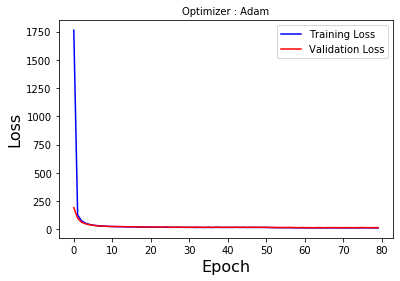

In [14]:
# 劃出 loss 值的圖
import matplotlib.pyplot as plt
%matplotlib inline
model_1.history['loss'] + hist_model.history['loss']

plt.title('Optimizer : Adam', fontsize=10)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.plot(model_1.history['loss'] + hist_model.history['loss'], color='b', label='Training Loss')
plt.plot(model_1.history['val_loss'] + hist_model.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

logs/000/trained_weights_final.h5 model, anchors, and classes loaded.
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.91 (63, 67) (120, 213)
kangaroo 0.98 (80, 0) (189, 222)
3.1760456299998623


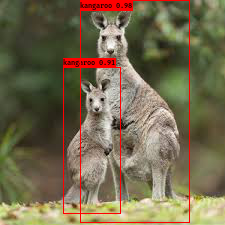

(416, 416, 3)
Found 3 boxes for img
kangaroo 0.72 (167, 26) (268, 146)
kangaroo 0.77 (104, 48) (155, 146)
kangaroo 0.91 (19, 73) (112, 135)
0.04944178699997792


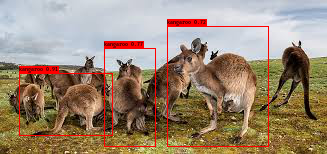

(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (46, 0) (391, 426)
0.05917939400023897


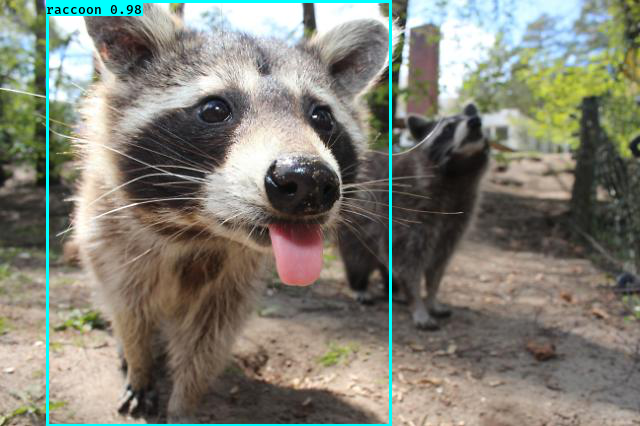

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.99 (4, 36) (108, 171)
raccoon 0.93 (115, 8) (252, 190)
0.04804323300004398


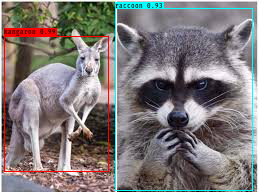

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.78 (11, 11) (140, 273)
raccoon 0.73 (12, 15) (155, 277)
0.05582124300008218


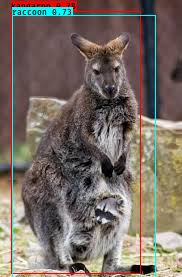

(416, 416, 3)
Found 4 boxes for img
kangaroo 0.61 (518, 17) (634, 149)
kangaroo 0.80 (451, 61) (609, 331)
kangaroo 0.98 (0, 57) (215, 328)
raccoon 0.99 (219, 36) (421, 338)
0.07018852800001696


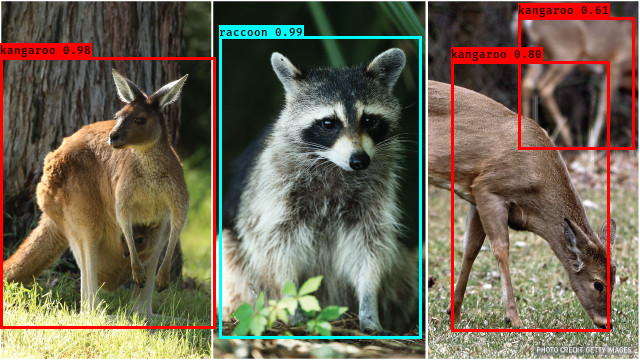

(416, 416, 3)
Found 3 boxes for img
kangaroo 0.95 (194, 33) (309, 126)
kangaroo 0.96 (7, 29) (110, 143)
kangaroo 0.97 (104, 50) (210, 145)
0.048365398999976605


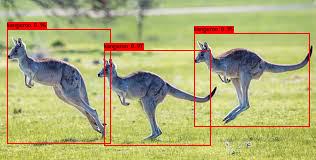

In [30]:
# 畫出多張預測圖

# 使用預訓練的權重來偵測物體
from yolo import YOLO
classes_path = 'class.txt'
log_dir = 'logs/000/' # 訓練好的模型儲存的路徑
yolo_model = YOLO(model_path=log_dir + 'trained_weights_final.h5', classes_path=classes_path)

from PIL import Image
import matplotlib.pyplot as plt
for file in os.listdir('test'):
    image = Image.open(os.path.join('test/', file))      # 讀取範例圖片
    r_img = yolo_model.detect_image(image)               # 執行 yolo 檢測，將回傳的圖片儲存在 r_image 中
    display(r_img)                               # 顯示 r_image，可觀察到圖片上已畫上 yolov3 所檢測的 object

In [31]:
# 偵測 Kangaroo.mp4 
from yolo import YOLO
import numpy as np
import time
import cv2
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

classes_path = 'class.txt'
log_dir = 'logs/000/' # 訓練好的模型儲存的路徑

yolo_model = YOLO(model_path=log_dir + 'trained_weights_final.h5', classes_path=classes_path)

def detect_video(yolo, video_path, output_path=""):
    import cv2
    vid = cv2.VideoCapture(video_path)
    if not vid.isOpened():
        raise IOError("Couldn't open webcam or video")
    video_FourCC    = int(vid.get(cv2.CAP_PROP_FOURCC))
    # 指定 video 編碼方式(此例使用 MP4)
    video_FourCC = cv2.VideoWriter_fourcc(*'MP4V')
    video_fps       = vid.get(cv2.CAP_PROP_FPS) 
    video_size      = (int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)),
                        int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    isOutput = True if output_path != "" else False
    if isOutput:
        out = cv2.VideoWriter(output_path, video_FourCC, video_fps, video_size)
    video_cnt = 0  
    video_playtime = []  
    while True:
        return_value, frame = vid.read()
        video_cnt += 1 
        if return_value == True : 
            image = Image.fromarray(frame)
            start_time = time.time() 
            image = yolo.detect_image(image)
            end_time = time.time()
            time_img = end_time - start_time  
            video_playtime.append(round(time_img, 3)) 
            result = np.asarray(image)
            cv2.putText(result, text='fps', org=(3, 15), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale=0.50, color=(255, 0, 0), thickness=2)
            if isOutput:
                out.write(result)
        else :  
            break
    vid.release()  # release vid resource
    out.release()  # release out resource
    return video_playtime, video_cnt 

# 1.偵測 Kangaroo.mp4
video_playtime, video_cnt = detect_video(yolo_model, video_path="video/Kangaroo.mp4", output_path="video/Kangaroo_new.mp4")
print('Kangaroo.mp4 total frames: ', video_cnt)  # 總共有多少 frames

# Kangaroo 平均 fps :
avg_fps = 1/np.mean(video_playtime)
print("Kangaroo.mp4 avg fps: %.3f" % avg_fps)

# 2.偵測 Raccoon.mp4
video_playtime, video_cnt = detect_video(yolo_model, video_path="video/Raccoon.mp4", output_path="video/Raccoon_new.mp4")
print('Raccoon.mp4 total frames: ', video_cnt)  # 總共有多少 frames

# Raccoon 平均 fps :
avg_fps = 1/np.mean(video_playtime)
print("Raccoon.mp4 avg fps: %.3f" % avg_fps)

Streaming output truncated to the last 5000 lines.
(416, 416, 3)
Found 0 boxes for img
0.044708408000133204
(416, 416, 3)
Found 0 boxes for img
0.04562341800010472
(416, 416, 3)
Found 0 boxes for img
0.04422642999998061
(416, 416, 3)
Found 0 boxes for img
0.04347310100001778
(416, 416, 3)
Found 0 boxes for img
0.043560384000102204
(416, 416, 3)
Found 0 boxes for img
0.04527112300002045
(416, 416, 3)
Found 0 boxes for img
0.045552320000297186
(416, 416, 3)
Found 0 boxes for img
0.044606087999909505
(416, 416, 3)
Found 0 boxes for img
0.044346358999973745
(416, 416, 3)
Found 0 boxes for img
0.04614234399969064
(416, 416, 3)
Found 0 boxes for img
0.049905694000244694
(416, 416, 3)
Found 0 boxes for img
0.04465649100029623
(416, 416, 3)
Found 0 boxes for img
0.04429175599989321
(416, 416, 3)
Found 0 boxes for img
0.04480942899999718
(416, 416, 3)
Found 0 boxes for img
0.04473915000016859
(416, 416, 3)
Found 0 boxes for img
0.04510897899990596
(416, 416, 3)
Found 0 boxes for img
0.044123379